In [1]:
from pyspark.sql import SparkSession

import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.window import Window

from pyspark.ml.feature import *
from pyspark.ml import Pipeline

from pyspark.sql.types import (
    ArrayType,
    StringType
)

import matplotlib.pyplot as plt
import seaborn as sns

# import sys
# sys.path.append('/usr/local/Anaconda3-5.1.0/lib/python3.6/site-packages')

from sparknlp.base import *
from sparknlp.annotator import *

from sparknlp.annotator import MultiClassifierDLApproach

sns.set_style('whitegrid')

In [2]:
spark = SparkSession.builder.appName('BDP') \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:4.2.3").getOrCreate()

conf = spark.sparkContext._conf.setAll([('spark.driver.memory','4g')])
# # ('spark.executor.memory', '10g')
# #print spark configuration settings
spark.sparkContext.getConf().getAll()

22/11/27 00:18:10 WARN Utils: Your hostname, betelgeuse resolves to a loopback address: 127.0.1.1; using 10.0.0.130 instead (on interface wlp0s20f3)
22/11/27 00:18:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/betelgeuse/miniconda3/envs/py39/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/betelgeuse/.ivy2/cache
The jars for the packages stored in: /home/betelgeuse/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-86aaa8d4-1537-4af3-ae3d-d957531af6ca;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.2.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlo

22/11/27 00:18:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


[('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.files',
  'file:///home/betelgeuse/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.2.3.jar,file:///home/betelgeuse/.ivy2/jars/com.typesafe_config-1.4.2.jar,file:///home/betelgeuse/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.ja

# 1. Data Exploration

### a) Read the movie synopsis data into Spark

In [3]:
df = spark.read.csv("/media/betelgeuse/Windows 10/Users/Manish Sihag/Desktop/UChicago/Classes/MSCA31013-Big-Data-Platforms/project/parsed_papers_1k.csv",
                    inferSchema=True, header=True,
                    multiLine=True, quote='\"', escape='\"')
df.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- body_text: string (nullable = true)
 |-- publish_time: timestamp (nullable = true)
 |-- journal: string (nullable = true)



### b) Print basic summary statistics of the data set

In [5]:
df.count()

1000

In [6]:
df.dtypes

[('paper_id', 'string'),
 ('title', 'string'),
 ('authors', 'string'),
 ('abstract', 'string'),
 ('body_text', 'string'),
 ('publish_time', 'timestamp'),
 ('journal', 'string')]

Since all the columns are strings, it doesn't make much sense to calculate mean, median, and other statitiscs on these columns

In [8]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+-----+-------+--------+---------+------------+-------+
|paper_id|title|authors|abstract|body_text|publish_time|journal|
+--------+-----+-------+--------+---------+------------+-------+
|       0|    0|      4|      30|        0|           0|      0|
+--------+-----+-------+--------+---------+------------+-------+



# 2. Build Models

### a) Use a SparkML pipeline to build NLP models to classify movies into the top 10 most popular tags

In [4]:
df = df.drop(*["paper_id", "title", "authors", "abstract", "publish_time"])

df.show(5)

+--------------------+--------------+
|           body_text|       journal|
+--------------------+--------------+
|Mycoplasma pneumo...|BMC Infect Dis|
|Since its discove...|    Respir Res|
|Surfactant protei...|    Respir Res|
|ET-1, ET-2, and E...|    Respir Res|
|RSV and PVM are v...|    Respir Res|
+--------------------+--------------+
only showing top 5 rows



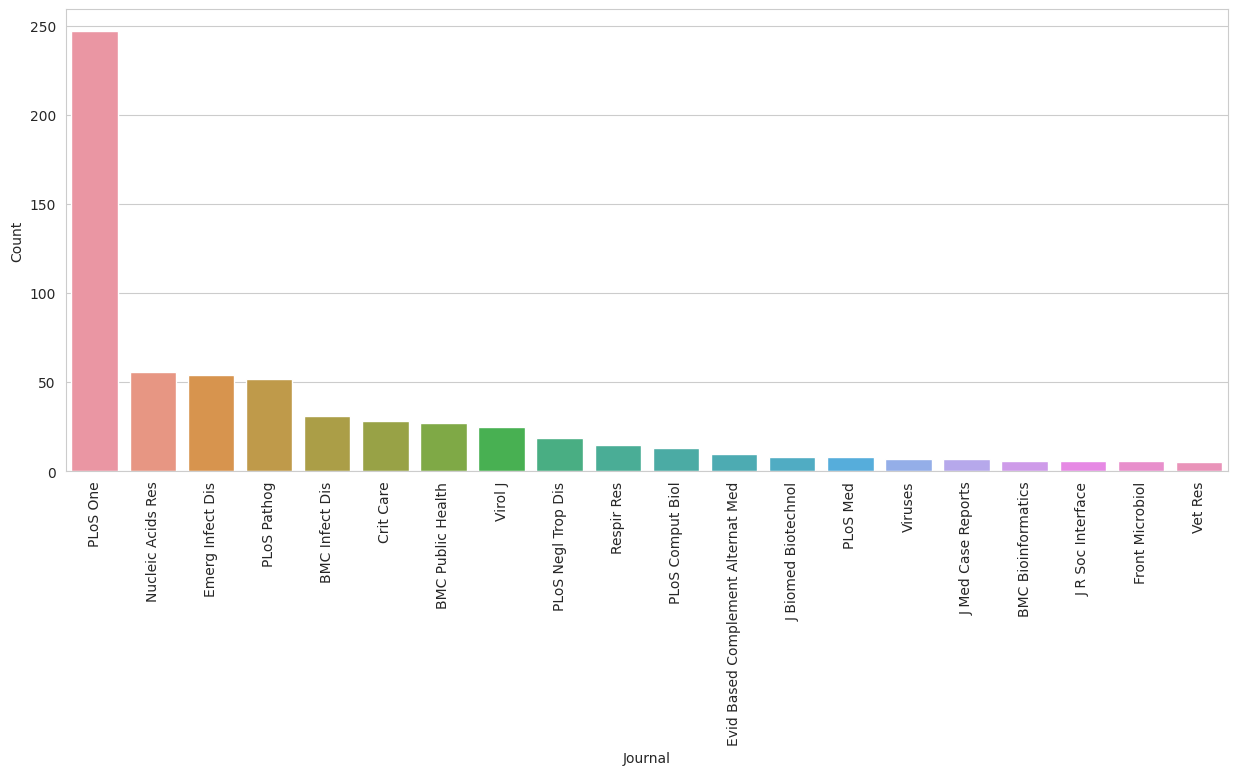

In [5]:
journals = df.groupBy("journal").count().orderBy("count", ascending=False).toPandas().head(20)

plt.figure(figsize=(15, 6))

sns.barplot(data=journals, x="journal", y="count")

plt.xticks(rotation=90)
plt.xlabel("Journal")
plt.ylabel("Count")

plt.show()

In [6]:
top10_journals = journals.head(20).journal.tolist()

In [7]:
df = df.filter(F.col("journal").isin(top10_journals))
df.count()

630

In [5]:
document_assembler = DocumentAssembler() \
            .setInputCol("body_text") \
            .setOutputCol("document") \
            .setCleanupMode("shrink_full")

tokenizer = Tokenizer() \
            .setInputCols("document") \
            .setOutputCol("token")
          
normalizer = Normalizer() \
            .setInputCols("token") \
            .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
            .setInputCols("normalized")\
            .setOutputCol("cleanTokens")\
            .setCaseSensitive(False)

lemma = LemmatizerModel.pretrained('lemma_antbnc') \
            .setInputCols("cleanTokens") \
            .setOutputCol("lemma")

glove_embeddings = WordEmbeddingsModel().pretrained() \
                        .setInputCols(["document", 'lemma'])\
                        .setOutputCol("embeddings")\
                        .setCaseSensitive(False)

embeddingsSentence = SentenceEmbeddings() \
                        .setInputCols(["document", "embeddings"]) \
                        .setOutputCol("sentence_embeddings") \
                        .setPoolingStrategy("AVERAGE")

embeddings_finisher = EmbeddingsFinisher() \
                        .setInputCols('sentence_embeddings') \
                        .setOutputCols('sentence_embeddings_vectors') \
                        .setOutputAsVector(True)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[ | ]glove_100d download started this may take some time.
Approximate size to download 145.3 MB
Download done! Loading the resource.
[OK!]


In [6]:
# classsifierdl = ClassifierDLApproach()\
#                         .setInputCols(["sentence_embeddings"])\
#                         .setOutputCol("category")\
#                         .setLabelColumn("journal")\
#                         .setMaxEpochs(20)\
#                         .setBatchSize(32)\
#                         .setLr(1e-2)
                        

pipeline = Pipeline(
    stages = [
        document_assembler,
        tokenizer,
        normalizer,
        stopwords_cleaner, 
        lemma, 
        glove_embeddings,
        embeddingsSentence,
        embeddings_finisher
    ]
)

In [7]:
train_df, test_df = df.randomSplit([0.05, 0.95], seed=42)
train_df.show(10, truncate = True)

+--------------------+-----------------+
|           body_text|          journal|
+--------------------+-----------------+
|(termed tRNA Ser ...|           EMBO J|
|An outbreak of no...| Emerg Infect Dis|
|Aplastic anemia, ...|          Virol J|
|Australia's first...|BMC Public Health|
|Avian influenza v...|     Yonsei Med J|
|Bone marrow conta...|         PLoS One|
|CD8+ T cells play...|    Front Immunol|
|Despite the antig...|      PLoS Pathog|
|During an influen...|    Ann Occup Hyg|
|Eukaryotic cells ...|Nucleic Acids Res|
+--------------------+-----------------+
only showing top 10 rows



In [8]:
embedded_texts = pipeline.fit(train_df).transform(train_df)

In [9]:
embedded_texts.printSchema()

root
 |-- body_text: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- token: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-

In [ ]:
embedded_texts.select("sentence_embeddings_vectors").show(5)

In [9]:
embedded_texts = embedded_texts.select(F.explode(F.col("sentence_embeddings_vectors")).alias("features"))
# embedded_texts.select("sentence_embeddings_vectors").show(5)

In [10]:
embedded_texts.show(5)

+--------------------+
|            features|
+--------------------+
|[-0.1601934581995...|
|[-0.1087049841880...|
|[0.04101908206939...|
|[-0.0707106888294...|
|[-0.0367011949419...|
+--------------------+
only showing top 5 rows



In [11]:
train_df.count(), test_df.count()

(530, 100)

In [12]:
clf_pipelineModel = clf_pipeline.fit(train_df)

2022-11-26 02:23:23.856382: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/32feec6dc2fa_classifier_dl11486200628654331224
2022-11-26 02:23:24.019733: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-11-26 02:23:24.019775: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/32feec6dc2fa_classifier_dl11486200628654331224
2022-11-26 02:23:24.019868: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 02:23:24.627175: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-11-2

Training started - epochs: 20 - learning_rate: 0.01 - batch_size: 32 - training_examples: 530 - classes: 20
Epoch 1/20 - 0.62s - loss: 47.24174 - acc: 0.38845485 - batches: 17
Epoch 2/20 - 0.15s - loss: 47.328625 - acc: 0.41189235 - batches: 17
Epoch 3/20 - 0.18s - loss: 47.328625 - acc: 0.41189235 - batches: 17
Epoch 4/20 - 0.16s - loss: 47.328625 - acc: 0.41189235 - batches: 17
Epoch 5/20 - 0.18s - loss: 47.328625 - acc: 0.41189235 - batches: 17
Epoch 6/20 - 0.16s - loss: 47.328625 - acc: 0.41189235 - batches: 17
Epoch 7/20 - 0.19s - loss: 47.328625 - acc: 0.41189235 - batches: 17
Epoch 8/20 - 0.18s - loss: 47.328625 - acc: 0.41189235 - batches: 17
Epoch 9/20 - 0.18s - loss: 47.328625 - acc: 0.41189235 - batches: 17
Epoch 10/20 - 0.15s - loss: 47.328625 - acc: 0.41189235 - batches: 17
Epoch 11/20 - 0.17s - loss: 47.328625 - acc: 0.41189235 - batches: 17
Epoch 12/20 - 0.16s - loss: 47.328625 - acc: 0.41189235 - batches: 17
Epoch 13/20 - 0.17s - loss: 47.328625 - acc: 0.41189235 - batc

In [13]:
preds = clf_pipelineModel.transform(test_df)

In [16]:
preds_df = preds.select("journal", "category.result").toPandas()

In [19]:
preds_df.loc[:, "result"] = preds_df["result"].apply(lambda x: x[0])
preds_df.head()

,journal,result
0,Evid Based Complement Alternat Med,PLoS One
1,PLoS One,PLoS One
2,PLoS One,PLoS One
3,PLoS One,PLoS One
4,PLoS One,PLoS One


In [22]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

y_true = preds_df.journal.tolist()
y_pred = preds_df.result.tolist()

print("Accuracy:", (accuracy_score(y_true, y_pred)))
print("Classification Report:", classification_report(y_true, y_pred))

Accuracy: 0.4
Classification Report:                                     precision    recall  f1-score   support

                BMC Bioinformatics       0.00      0.00      0.00         2
                    BMC Infect Dis       0.00      0.00      0.00         5
                 BMC Public Health       0.00      0.00      0.00         6
                         Crit Care       0.00      0.00      0.00         5
                  Emerg Infect Dis       0.00      0.00      0.00         8
Evid Based Complement Alternat Med       0.00      0.00      0.00         1
                J Med Case Reports       0.00      0.00      0.00         2
                 J R Soc Interface       0.00      0.00      0.00         2
                 Nucleic Acids Res       0.00      0.00      0.00         7
                  PLoS Comput Biol       0.00      0.00      0.00         3
                          PLoS Med       0.00      0.00      0.00         2
                PLoS Negl Trop Dis       0.00     

/home/betelgeuse/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/betelgeuse/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/betelgeuse/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [23]:
xx = preds.select("embeddings", "sentence_embeddings").toPandas()

In [24]:
xx

,embeddings,sentence_embeddings
0,"[(word_embeddings, 0, 9, Depression, {'sentenc...","[(sentence_embeddings, 0, 25681, Depression is..."
1,"[(word_embeddings, 0, 12, Staphylococci, {'sen...","[(sentence_embeddings, 0, 28496, Staphylococci..."
2,"[(word_embeddings, 0, 9, Toxoplasma, {'sentenc...","[(sentence_embeddings, 0, 24862, Toxoplasma go..."
3,"[(word_embeddings, 2, 7, common, {'sentence': ...","[(sentence_embeddings, 0, 31529, A common meth..."
4,"[(word_embeddings, 2, 4, new, {'sentence': '0'...","[(sentence_embeddings, 0, 18877, A new highly ..."
...,...,...
95,"[(word_embeddings, 0, 6, Viruses, {'sentence':...","[(sentence_embeddings, 0, 40962, Viruses need ..."
96,"[(word_embeddings, 3, 8, test, {'sentence': '0...","[(sentence_embeddings, 0, 10688, We tested 332..."
97,"[(word_embeddings, 5, 13, molecular, {'sentenc...","[(sentence_embeddings, 0, 14469, When molecula..."
98,"[(word_embeddings, 4, 9, genus, {'sentence': '...","[(sentence_embeddings, 0, 5464, the genera Ept..."


In [34]:
len(xx.sentence_embeddings[0][0].embeddings)

100

In [11]:
from pyspark.ml.clustering import LDA

In [52]:
pp = preds.select('sentence_embeddings.embeddings').withColumnRenamed("embeddings", "features")
pp.show(5)

+--------------------+
|            features|
+--------------------+
|[[-0.07619757, 0....|
|[[-0.16363257, 0....|
|[[-0.11517252, 0....|
|[[-0.13065161, 0....|
|[[-0.10602315, 0....|
+--------------------+
only showing top 5 rows



In [ ]:
p2 = preds.select("*", F.explode("sentence_embeddings.embeddings").alias("embeddings"))

results = results.withColumn(
    "features",
    self.udfs['convertToVectorUDF'](F.col("embeddings"))
)

In [12]:
num_topics = 5
max_iterations = 10

lda = LDA(k=num_topics, seed=42)
lda.setMaxIter(max_iterations)
lda_model = lda.fit(embedded_texts)

22/11/27 00:20:53 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/27 00:20:53 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


ERROR:root:KeyboardInterrupt while sending command.                 (0 + 1) / 1]
Traceback (most recent call last):
  File "/home/betelgeuse/miniconda3/envs/py39/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/betelgeuse/miniconda3/envs/py39/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/betelgeuse/miniconda3/envs/py39/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [13]:
lda_model.describeTopics().show()

NameError: name 'lda_model' is not defined

In [ ]:
embedded_texts = pipeline.fit(train_df).transform(train_df)